In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

from torch.utils.data import TensorDataset, DataLoader

from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST, CIFAR10

# Note: we will load the IMDB dataset from tensorflow.keras...
from tensorflow.keras.datasets import imdb
import tensorflow as tf
from tensorflow import keras
import gc
from sklearn.model_selection import train_test_split

from torch.nn import Linear, Conv2d, MaxPool2d, Dropout, Flatten, ReLU
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### PyTorch version: ' + torch.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())


------------
### Python version: 3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:25:59) 
[GCC 10.3.0]
### NumPy version: 1.24.4
### Scikit-learn version: 0.24.2
### PyTorch version: 1.13.1
------------


In [2]:
seed = 42
np.random.seed(seed)

In [3]:
# check if the unzipped directory exists, if not, unzip it
directory = "project_data"
zippedDir = directory + ".zip"
if not os.path.isdir(directory):
    import zipfile
    with zipfile.ZipFile(zippedDir, 'r') as myzip:
        myzip.extractall(directory)


In [4]:
from PIL import Image
from pathlib import Path
dirNames = []

def getData():
    imageCounter = 0
    images = []
    labels = []
    for classes in Path(directory).iterdir():
        dirNames.append(os.path.basename(classes))
        for image in classes.iterdir():
            imageCounter += 1
            img = np.array(Image.open(image).convert("RGB"))
            img = np.transpose(img, (2, 0, 1))
            images.append(img)
            labels.append(os.path.basename(classes))
    return np.array(images), np.array(labels), imageCounter

In [5]:
import matplotlib.pyplot as plt

def visualizeData(x, y):
    # visualize to make sure images have loaded with correct labels
    plt.figure(figsize=(10, 10))
    for i in range(9):
        # For visualization, transpose back to (H, W, C)
        img_to_show = np.transpose(x[i], (1, 2, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img_to_show)
        plt.title(y[i])
        plt.axis("off")
    plt.show()

In [6]:
images, labels, imageCounter = getData()

print(imageCounter)

4757


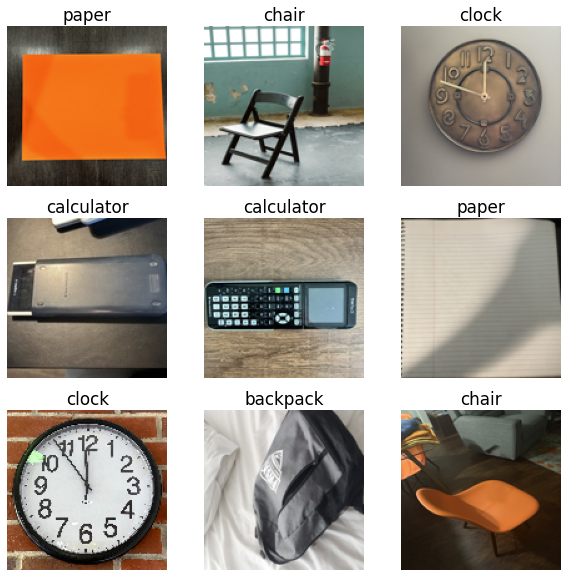

In [7]:
# lets grab a train val split 80-20
train_x, splitX, train_y, splitY = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=seed
)
# 50-50 of the remaining 20 so 60% train, 20% validation, 20% test
val_x, test_x, val_y, test_y = train_test_split(
    splitX, splitY, test_size=0.5, stratify=splitY, random_state=seed
)

visualizeData(train_x, train_y)

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# need to encode th elabels
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)
val_y_encoded = label_encoder.transform(val_y)
test_y_encoded =label_encoder.transform(test_y)

In [100]:
import copy

class EarlyStopping:
    def __init__(self, patience=1000, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

    def get_best_model(self, model_class, *args, **kwargs):
        best_model = model_class(*args, **kwargs)
        best_model.load_state_dict(self.best_model_state)
        return best_model

# Create a class to implement model checkpointing
class ModelCheckpoint:
    def __init__(self, model, checkpoint_path):
        self.model = model
        self.checkpoint_path = checkpoint_path
        self.best_score = None

    def __call__(self, val_loss):
        if self.best_score is None or val_loss < self.best_score:
            self.best_score = val_loss
            torch.save(self.model.state_dict(), self.checkpoint_path)

In [110]:
import torchvision.models as models
import timm
from joblib import load
from joblib import dump

images_to_show = []
pred_labels = []
true_labels = []

class DenseNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier, self).__init__()
        # this is densenet but canm do others
        self.base_model = models.densenet121(pretrained=True)
        
        # freeze original model
        for param in self.base_model.features.parameters():
            param.requires_grad = False

        for name, param in self.base_model.features.named_parameters():
            if "denseblock4" in name or "norm5" in name:
                param.requires_grad = True
            
        # buikd a classifider here, add whatever you want
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)
    
class DenseNetClassifier201(nn.Module):
    def __init__(self, num_classes):
        super(DenseNetClassifier201, self).__init__()
        self.base_model = models.densenet201(pretrained=True)
        
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        # buikd a classifider here, add whatever you want
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        return self.base_model(x)
    
class ResNetClassifier50(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier50, self).__init__()
        # this is densenet but canm do others
        self.base_model = models.resnet50(pretrained=True)
        
        # freeze original model
        # for param in self.base_model.parameters():
        #     param.requires_grad = False
            
        # buikd a classifider here, add whatever you want
        self.base_model = models.resnet50(pretrained=True)
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.base_model(x)
    
class EfficientNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # self.base_model.classifier = nn.Linear(self.base_model.classifier.in_features, num_classes)
        in_features = self.base_model.classifier.in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.base_model(x)
    
import torch.nn as nn
import torchvision.models as models

class ResNetClassifier128(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifier128, self).__init__()
        
        self.base_model = models.resnet34(pretrained=True)
        
        self.base_model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.base_model.maxpool = nn.Identity()  

        # Replace classifier
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.base_model(x)

    
# if os.path.exists('classSuppliesModel.pt'):
#     model = load('classSuppliesModel.pt')
#     print("Pretrained model loaded")
# else:
num_classes = len(dirNames) 
model = DenseNetClassifier(num_classes)
# model = DenseNetClassifier201(num_classes)
# model = ResNetClassifier50(num_classes)
# model = EfficientNetClassifier(num_classes)
# model = ResNetClassifier128(num_classes)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
model.loss_func = loss_fn
model.optimizer = opt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

max_epochs = 100

# kinda just combined thins from this link: https://pytorch.org/vision/0.9/transforms.html and from Alex's notebook
# also saves time loading from the initial directory above
# transform = transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                                  std=[0.5, 0.5, 0.5])

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

# val_transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
# ])

# transformed_train_x = []
# for img in train_x:
#     transformed_train_x.append(train_transform(img))

# transformed_val_x = []
# for img in val_x:
#     transformed_val_x.append(val_transform(img))

# train_y_tensor = torch.tensor(train_y)
# val_y_tensor = torch.tensor(val_y)

# train_dataset = torch.utils.data.TensorDataset(torch.stack(transformed_train_x), train_y_tensor)
# val_dataset = torch.utils.data.TensorDataset(torch.stack(transformed_val_x), val_y_tensor)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

train_dataset = TensorDataset(
torch.tensor(train_x, dtype=torch.float32), 
torch.tensor(train_y_encoded, dtype=torch.long)
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(
    torch.tensor(val_x, dtype=torch.float32), 
    torch.tensor(val_y_encoded, dtype=torch.long)
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

early_stopping = EarlyStopping(patience=5)
model_checkpoint = ModelCheckpoint(model=model, checkpoint_path='best_model.pt')

for epoch in range(max_epochs):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation step
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    iters = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            output = model(images)

            _, predicted = torch.max(output, dim=1)

            loss = loss_fn(output, labels)
            val_loss += loss.item() * images.size(0)

            correct += (predicted == labels).sum().item() 
            total += labels.size(0) 
            if len(images_to_show) <= 35: # get 35 images
                for i in range(len(images)):
                    images_to_show.append(images[i].cpu())
                    pred_labels.append(predicted[i].item())
                    true_labels.append(labels[i].item())
            # iters += 1 # keeping track of how any vcals we do (lazy but works)

    accuracy = correct / total

    val_loss /= len(val_loader.dataset)

    #if epoch % 10 == 0:

    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

    # check if we should save the model
    model_checkpoint(val_loss)

    # check if we should stop
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break
dump(model, 'SBDenseNetClassifier.pt')

Epoch 0, Train Loss: 0.6969, Val Loss: 0.4269, Accuracy: 0.8887
Epoch 1, Train Loss: 0.2580, Val Loss: 0.4056, Accuracy: 0.8866
Epoch 2, Train Loss: 0.1508, Val Loss: 0.4119, Accuracy: 0.8992
Epoch 3, Train Loss: 0.0958, Val Loss: 0.4070, Accuracy: 0.9076
Epoch 4, Train Loss: 0.0977, Val Loss: 0.4290, Accuracy: 0.9076
Epoch 5, Train Loss: 0.0726, Val Loss: 0.4175, Accuracy: 0.9097
Epoch 6, Train Loss: 0.0789, Val Loss: 0.4109, Accuracy: 0.9118
Early stopping


['SBDenseNetClassifier.pt']

In [111]:
def visualization(test_images_to_show, test_pred_labels, test_true_labels):
    plt.figure(figsize=(50, 50))
    subplotRow = 1
    # we are going tod ispaly 9 random images fromt he model
    for i in range(len(test_images_to_show)):
        # random_index = random.randint(0, len(pred_labels)-1)
        if i < 8:
            random_index = random.randint(0, len(pred_labels)-1)
            predicted_class = label_encoder.inverse_transform([pred_labels[random_index]])[0]
            true_class = label_encoder.inverse_transform([true_labels[random_index]])[0]

            img = images_to_show[random_index].numpy()
            img = np.transpose(img, (1, 2, 0))
            img = (img - img.min()) / (img.max() - img.min())
            # if round(len(test_images_to_show)/9+0.5) > i:
            #     subplotRow += 1
            plt.subplot(1, 8, i+1)
            plt.imshow(img)
            plt.title(f"True: {true_class}\nPred: {predicted_class}")
            plt.axis('off')
        else:
            break
#         predicted_class = label_encoder.inverse_transform([pred_labels[i]])[0]
#         true_class = label_encoder.inverse_transform([true_labels[i]])[0]

#         img = images_to_show[i].numpy()
#         img = np.transpose(img, (1, 2, 0))
#         img = (img - img.min()) / (img.max() - img.min())
#         if round(len(test_images_to_show)/9+0.5) > i:
#             subplotRow += 1
#         plt.subplot(subplotRow, round(len(test_images_to_show)/9+0.5), i+1)
#         plt.imshow(img)
#         plt.title(f"True: {true_class}\nPred: {predicted_class}")
#         plt.axis('off')

    plt.tight_layout()
    plt.show()

In [112]:
model.eval()
test_loss = 0
correct = 0
total = 0
iters = 0

test_images_to_show = []
test_pred_labels = []
test_true_labels = []

# # time to test if it works
test_dataset = TensorDataset(
    torch.tensor(test_x, dtype=torch.float32), 
    torch.tensor(test_y_encoded, dtype=torch.long)
    )
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)

        _, predicted = torch.max(output, dim=1)

        loss = loss_fn(output, labels)
        test_loss += loss.item() * images.size(0)

        correct += (predicted == labels).sum().item() 
        total += labels.size(0) 
        
        # if len(test_images_to_show) <= 35: # get 35 images
        for i in range(len(images)):
            test_images_to_show.append(images[iters].cpu())
            test_pred_labels.append(predicted[iters].item())
            test_true_labels.append(labels[iters].item())
        

accuracy = correct / total

test_loss /= len(test_loader.dataset)

#if epoch % 10 == 0:

print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Test Loss: 0.3257, Accuracy: 0.9139


In [113]:
print(len(test_images_to_show))

476


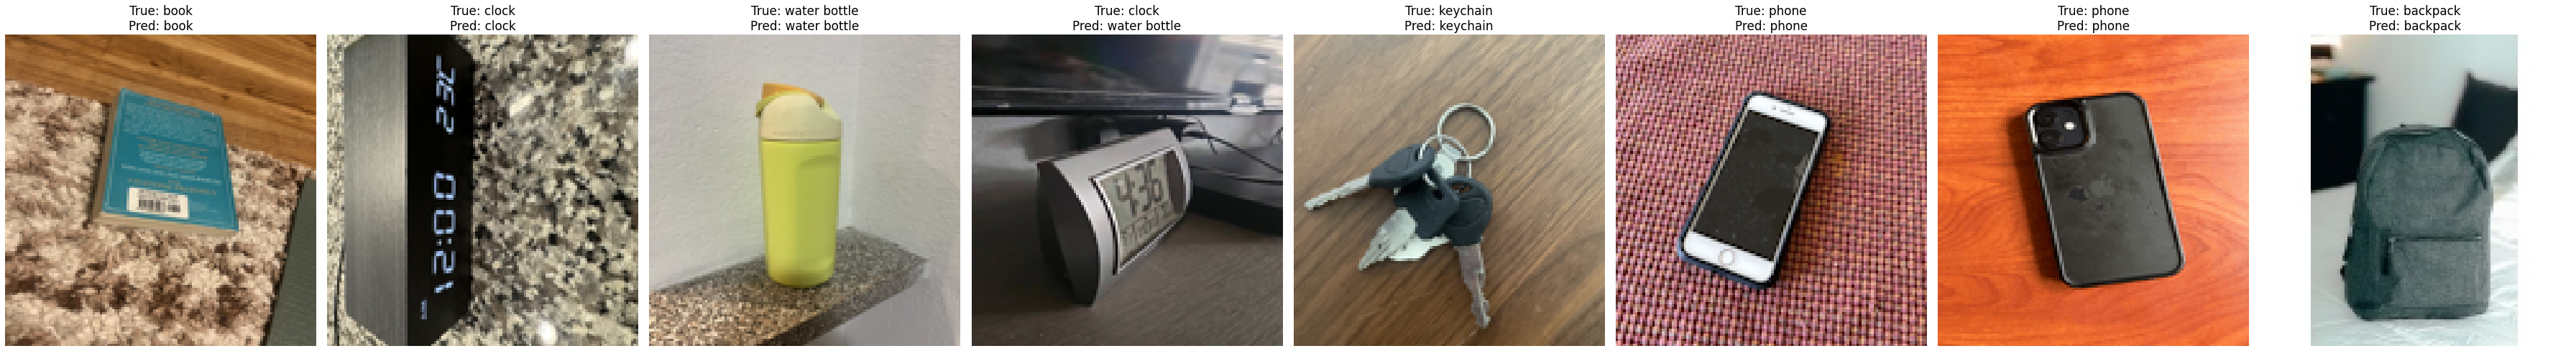

In [114]:
visualization(test_images_to_show, test_pred_labels, test_true_labels)